# Demonstrate new EMC² capabilities (P3 implementation)

### Imports

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import emc2

### Set instrument classes. Specify site for KAZR to determine radar sensitivity.

In [2]:
KAZR = emc2.core.instruments.KAZR('sgp')
HSRL = emc2.core.instruments.HSRL()
print("Instrument class generation done!")

Instrument class generation done!


### Load sample E3SMv3 output file representing the ENA region (4 columns, i.e., spatial data)

In [4]:
gen_subset = False  # if True generating data subset

model_path = 'example_data/v3.EMC2.test.subset.20250515.nc'   

v3_sample = xr.open_dataset(model_path)
v3_sample

<xarray.Dataset> Size: 2MB
Dimensions:                                    (
                                                ncol_30w_to_26w_37.1n_to_41.5n: 4,
                                                lev: 80, ilev: 81,
                                                P3_input_dim: 16,
                                                P3_output_dim: 32, cosp_prs: 7,
                                                nbnd: 2, cosp_tau: 7,
                                                cosp_scol: 10, cosp_ht: 40,
                                                cosp_temp: 40, cosp_sr: 15,
                                                cosp_sza: 5, cosp_htmisr: 16,
                                                cosp_tau_modis: 7,
                                                cosp_reffice: 6,
                                                cosp_reffliq: 6, time: 25)
Coordinates: (12/16)
  * lev                                        (lev) float64 640B 0.1236 ... ...
  * ilev                                       (ilev) float64 648B 0.1 ... 1e+03
  * P3_input_dim                               (P3_input_dim) int32 64B 1 ... 16
  * P3_output_dim                              (P3_output_dim) int32 128B 1 ....
  * cosp_prs                                   (cosp_prs) float64 56B 9e+04 ....
  * cosp_tau                                   (cosp_tau) float64 56B 0.15 .....
    ...                                         ...
  * cosp_sza                                   (cosp_sza) float64 40B 0.0 ......
  * cosp_htmisr                                (cosp_htmisr) float64 128B 0.0...
  * cosp_tau_modis                             (cosp_tau_modis) float64 56B 0...
  * cosp_reffice                               (cosp_reffice) float64 48B 5e-...
  * cosp_reffliq                               (cosp_reffliq) float64 48B 4e-...
  * time                                       (time) object 200B 2010-01-24 ...
Dimensions without coordinates: ncol_30w_to_26w_37.1n_to_41.5n, nbnd
Data variables: (12/108)
    lat_30w_to_26w_37.1n_to_41.5n              (ncol_30w_to_26w_37.1n_to_41.5n) float64 32B ...
    lon_30w_to_26w_37.1n_to_41.5n              (ncol_30w_to_26w_37.1n_to_41.5n) float64 32B ...
    hyam                                       (lev) float64 640B ...
    hybm                                       (lev) float64 640B ...
    P0                                         float64 8B ...
    hyai                                       (ilev) float64 648B ...
    ...                                         ...
    so4_a2_30w_to_26w_37.1n_to_41.5n           (time, lev, ncol_30w_to_26w_37.1n_to_41.5n) float32 32kB ...
    so4_a3_30w_to_26w_37.1n_to_41.5n           (time, lev, ncol_30w_to_26w_37.1n_to_41.5n) float32 32kB ...
    so4_a5_30w_to_26w_37.1n_to_41.5n           (time, lev, ncol_30w_to_26w_37.1n_to_41.5n) float32 32kB ...
    soa_a1_30w_to_26w_37.1n_to_41.5n           (time, lev, ncol_30w_to_26w_37.1n_to_41.5n) float32 32kB ...
    soa_a2_30w_to_26w_37.1n_to_41.5n           (time, lev, ncol_30w_to_26w_37.1n_to_41.5n) float32 32kB ...
    soa_a3_30w_to_26w_37.1n_to_41.5n           (time, lev, ncol_30w_to_26w_37.1n_to_41.5n) float32 32kB ...
Attributes: (12/17)
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         f2cb64d04e
    product:           model-output
    realm:             atmos
    case:              v3.EMC2.test.F2010.nudged.PD
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@llnl.gov
    initial_file:      /glade/campaign/uwyo/wyom0191/cime/inputdata/atm/cam/i...
    topography_file:   /glade/campaign/uwyo/wyom0191/cime/inputdata/atm/cam/t...
    time_period_freq:  hour_1

## Processing
---

### Generate `E3SMv3` class objects.
Here, we generate two object:
1. `e3sm_full_p3_mcp` - will be used to generate full P3-compliant output (surface area from 3-parameter ice LUT). Note that we will process using the microphysics scheme approach but the radiation scheme approach can be used as well — faster processing but without higher radar moments
2. `e3sm_current_rad` — will be used to generate output equivalent to the operation of E3SMv3 (radiation scheme approach; using equivalent volume spheres)

In the preprocessed output data, we can see that the EMC² code detects spatial data and therefore stacks it for processing. Also note that the lat/lon suffixes are removed from the  `col` coordinates.

### Note: By default, the `E3SMv1` and its inherited classes (`E3SMv3`) do not forward calculate radar and lidar observables for rain (`pl` class) since per the model's radiation scheme logic, the model is "blind" to rain hydrometeors. This can be changed by setting `include_rain_in_rt=True` during the model class initialization

In [5]:
e3sm_full_p3_mcp = emc2.core.model.E3SMv3(model_path, all_appended_in_lat=True, appended_str=True, instrument=KAZR)  # any instrument will do

e3sm_current_rad = emc2.core.model.E3SMv3(
    model_path, all_appended_in_lat=True, appended_str=True, instrument=KAZR, use_hybrid_scat=2
)  # Take the hybrid approach #2 (we take the effective density from the 3-parameter LUT, but then fold to equivalent volume spheres).
e3sm_current_rad.fluffy = None

e3sm_full_p3_mcp.ds  # shows the loaded dataset

Using P3 microphysics option; verify that model output includes the following fields required for EMC² to operate properly:
1. Rime mass (CLDRIM)
2. Rime volume (BVRIM)

example_data/v3.EMC2.test.subset.20250515.nc is a regional output dataset; Stacking the time, lat, and lon dims for processing with EMC^2.
Using P3 microphysics option; verify that model output includes the following fields required for EMC² to operate properly:
1. Rime mass (CLDRIM)
2. Rime volume (BVRIM)

example_data/v3.EMC2.test.subset.20250515.nc is a regional output dataset; Stacking the time, lat, and lon dims for processing with EMC^2.


<xarray.Dataset> Size: 3MB
Dimensions:              (lev: 80, ilev: 81, P3_input_dim: 16,
                          P3_output_dim: 32, cosp_prs: 7, nbnd: 2, cosp_tau: 7,
                          cosp_scol: 10, cosp_ht: 40, cosp_temp: 40,
                          cosp_sr: 15, cosp_sza: 5, cosp_htmisr: 16,
                          cosp_tau_modis: 7, cosp_reffice: 6, cosp_reffliq: 6,
                          time_lat_lon: 100, ncol_tmp: 4, time_tmp: 25)
Coordinates: (12/20)
  * ilev                 (ilev) float64 648B 0.1 0.1472 0.2166 ... 997.0 1e+03
  * P3_input_dim         (P3_input_dim) int32 64B 1 2 3 4 5 6 ... 12 13 14 15 16
  * P3_output_dim        (P3_output_dim) int32 128B 1 2 3 4 5 ... 28 29 30 31 32
  * cosp_prs             (cosp_prs) float64 56B 9e+04 7.4e+04 ... 2.45e+04 9e+03
  * cosp_tau             (cosp_tau) float64 56B 0.15 0.8 2.45 ... 41.5 100.0
  * cosp_scol            (cosp_scol) int32 40B 1 2 3 4 5 6 7 8 9 10
    ...                   ...
  * lev                  (lev) float64 640B 998.5 993.8 986.2 ... 0.1819 0.1236
  * ncol_tmp             (ncol_tmp) int64 32B 0 1 2 3
  * time_tmp             (time_tmp) datetime64[ns] 200B 2010-01-24T08:00:00 ....
  * time_lat_lon         (time_lat_lon) object 800B MultiIndex
  * ncol                 (time_lat_lon) int64 800B 0 0 0 0 0 0 0 ... 3 3 3 3 3 3
  * time                 (time_lat_lon) datetime64[ns] 800B 2010-01-24T08:00:...
Dimensions without coordinates: nbnd
Data variables: (12/118)
    hyam                 (lev) float64 640B 0.0003352 0.001392 ... 0.0001236
    hybm                 (lev) float64 640B 0.9982 0.9924 0.9831 ... 0.0 0.0 0.0
    P0                   float64 8B ...
    hyai                 (ilev) float64 648B dask.array<chunksize=(81,), meta=np.ndarray>
    hybi                 (ilev) float64 648B dask.array<chunksize=(81,), meta=np.ndarray>
    cosp_prs_bnds        (cosp_prs, nbnd) float64 112B dask.array<chunksize=(7, 2), meta=np.ndarray>
    ...                   ...
    Fr                   (time_lat_lon, lev) float64 64kB nan nan ... nan nan
    rho_r                (time_lat_lon, lev) float64 64kB nan nan ... nan nan
    qi_norm              (time_lat_lon, lev) float64 64kB nan nan ... nan nan
    lambda_ice           (time_lat_lon, lev) float64 64kB nan nan ... nan nan
    mu_ice               (time_lat_lon, lev) float64 64kB nan nan ... nan nan
    N0_norm_ice          (time_lat_lon, lev) float64 64kB nan nan ... nan nan
Attributes: (12/21)
    title:                EAM History file information
    source:               E3SM Atmosphere Model
    source_id:            f2cb64d04e
    product:              model-output
    realm:                atmos
    case:                 v3.EMC2.test.F2010.nudged.PD
    ...                   ...
    topography_file:      /glade/campaign/uwyo/wyom0191/cime/inputdata/atm/ca...
    time_period_freq:     hour_1
    _file_dates:          ['20100124']
    _file_times:          ['080000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

### Run processing. Since the generated subcolumns are randomized and we compare two forward-calculation approaches, we will have some differences in subcolumn allocation and q-N values. In case of comparison of variants of the same approach (microphysics or radiation), we could easily first generate the subcolumns for one approach and then copy the subcolumn generator output to the other approach's object, without rerunning the generator.

In [6]:
N_sub = 8  # specify the number of subcolumns
process_lidar = True
process_radar = True

if process_lidar:
    if not process_radar:
        unstack_dims=True
        finalize_fields=True  # finalize fields (set `0` to `NaN`) only once processing of all instruments is completed
    else:
        unstack_dims = False  # we unstack dimensions only once processing is completed (stacking-unstacking is currently irreversible)
        finalize_fields = False
    e3sm_full_p3_mcp = emc2.simulator.main.make_simulated_data(
        e3sm_full_p3_mcp, HSRL, N_sub, do_classify=True, convert_zeros_to_nan=True,
        unstack_dims=unstack_dims, finalize_fields=finalize_fields, use_rad_logic=False
    )
    e3sm_current_rad = emc2.simulator.main.make_simulated_data(
        e3sm_current_rad, HSRL, N_sub, do_classify=True, convert_zeros_to_nan=True,
        unstack_dims=unstack_dims, finalize_fields=finalize_fields)
    print("==========\n\nlidar processing done!\n\n==========")
if process_radar:
    if process_lidar:
        skip_subcol_gen = True  # subcolumns were already generated in lidar processing (save computation and ensure radar-lidar consistent)
    else:
        skip_subcol_gen = False
    e3sm_full_p3_mcp = emc2.simulator.main.make_simulated_data(
        e3sm_full_p3_mcp, KAZR, N_sub, do_classify=True, convert_zeros_to_nan=True,
        unstack_dims=True, skip_subcol_gen=skip_subcol_gen, finalize_fields=True, use_rad_logic=False)
    e3sm_current_rad = emc2.simulator.main.make_simulated_data(
        e3sm_current_rad, KAZR, N_sub, do_classify=True, convert_zeros_to_nan=True,
        unstack_dims=True, skip_subcol_gen=skip_subcol_gen, finalize_fields=True)
    print("==========\n\nradar processing done!\n\n==========")

## Creating subcolumns...
No convective processing for E3SMv3
Now performing parallel stratiform hydrometeor allocation in subcolumns
Fully overcast cl & ci in 0 voxels
Done! total processing time = 4.93s
Now performing parallel strat precipitation allocation in subcolumns
Fully overcast pl & pi in 0 voxels
Done! total processing time = 3.48s
Found relative variance field (RELVAR) in dataset - using it!
Now distributing q in subcolumns in parallel
Generating lidar moments...
Generating stratiform lidar variables using microphysics logic (slowest processing)
Generating strat lidar variables for hyd class cl (P3 rad; P3 mcphys; Mie=0)
Doing parallel lidar calculations for cl
Stratiform moment for class cl progress: 50/100
Stratiform moment for class cl progress: 0/100
Generating strat lidar variables for hyd class ci (P3 rad; P3 mcphys; Mie=0)
Doing parallel lidar calculations for ci
Stratiform moment for class ci progress: 50/100
Stratiform moment for class ci progress: 0/100
Done! tota

### Examine output (fully processed) simulated dataset. Note that in the case of the microphysics approach, EMC² also calculates the mean Doppler velocity and spectral width (essentially the microphysical broadening term at the moment)

In [7]:
e3sm_full_p3_mcp.ds

<xarray.Dataset> Size: 26MB
Dimensions:                           (lev: 80, ilev: 81, P3_input_dim: 16,
                                       P3_output_dim: 32, cosp_prs: 7, nbnd: 2,
                                       cosp_tau: 7, cosp_scol: 10, cosp_ht: 40,
                                       cosp_temp: 40, cosp_sr: 15, cosp_sza: 5,
                                       cosp_htmisr: 16, cosp_tau_modis: 7,
                                       cosp_reffice: 6, cosp_reffliq: 6,
                                       ncol: 4, time: 25, subcolumn: 8)
Coordinates: (12/18)
  * ilev                              (ilev) float64 648B 0.1 0.1472 ... 1e+03
  * P3_input_dim                      (P3_input_dim) int32 64B 1 2 3 ... 15 16
  * P3_output_dim                     (P3_output_dim) int32 128B 1 2 3 ... 31 32
  * cosp_prs                          (cosp_prs) float64 56B 9e+04 ... 9e+03
  * cosp_tau                          (cosp_tau) float64 56B 0.15 0.8 ... 100.0
  * cosp_scol                         (cosp_scol) int32 40B 1 2 3 4 5 6 7 8 9 10
    ...                                ...
  * cosp_reffice                      (cosp_reffice) float64 48B 5e-06 ... 7....
  * cosp_reffliq                      (cosp_reffliq) float64 48B 4e-06 ... 2....
  * lev                               (lev) float64 640B 998.5 993.8 ... 0.1236
  * ncol                              (ncol) int64 32B 0 1 2 3
  * time                              (time) datetime64[ns] 200B 2010-01-24T0...
  * subcolumn                         (subcolumn) int64 64B 0 1 2 3 4 5 6 7
Dimensions without coordinates: nbnd
Data variables: (12/179)
    hyam                              (lev) float64 640B 0.0003352 ... 0.0001236
    hybm                              (lev) float64 640B 0.9982 0.9924 ... 0.0
    P0                                float64 8B ...
    hyai                              (ilev) float64 648B dask.array<chunksize=(81,), meta=np.ndarray>
    hybi                              (ilev) float64 648B dask.array<chunksize=(81,), meta=np.ndarray>
    cosp_prs_bnds                     (cosp_prs, nbnd) float64 112B dask.array<chunksize=(7, 2), meta=np.ndarray>
    ...                                ...
    sub_col_Ze_att_tot_strat          (subcolumn, time, lev, ncol) float64 512kB ...
    Ze_min                            (time, lev, ncol) float64 64kB -87.45 ....
    sub_col_Ze_tot                    (subcolumn, time, lev, ncol) float64 512kB ...
    sub_col_Ze_att_tot                (subcolumn, time, lev, ncol) float64 512kB ...
    detect_mask                       (subcolumn, time, lev, ncol) bool 64kB ...
    phase_mask_KAZR_sounding_all_hyd  (subcolumn, time, lev, ncol) float64 512kB ...
Attributes: (12/21)
    title:                EAM History file information
    source:               E3SM Atmosphere Model
    source_id:            f2cb64d04e
    product:              model-output
    realm:                atmos
    case:                 v3.EMC2.test.F2010.nudged.PD
    ...                   ...
    topography_file:      /glade/campaign/uwyo/wyom0191/cime/inputdata/atm/ca...
    time_period_freq:     hour_1
    _file_dates:          ['20100124']
    _file_times:          ['080000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

In [8]:
e3sm_current_rad.ds

<xarray.Dataset> Size: 23MB
Dimensions:                           (lev: 80, ilev: 81, P3_input_dim: 16,
                                       P3_output_dim: 32, cosp_prs: 7, nbnd: 2,
                                       cosp_tau: 7, cosp_scol: 10, cosp_ht: 40,
                                       cosp_temp: 40, cosp_sr: 15, cosp_sza: 5,
                                       cosp_htmisr: 16, cosp_tau_modis: 7,
                                       cosp_reffice: 6, cosp_reffliq: 6,
                                       ncol: 4, time: 25, subcolumn: 8)
Coordinates: (12/18)
  * ilev                              (ilev) float64 648B 0.1 0.1472 ... 1e+03
  * P3_input_dim                      (P3_input_dim) int32 64B 1 2 3 ... 15 16
  * P3_output_dim                     (P3_output_dim) int32 128B 1 2 3 ... 31 32
  * cosp_prs                          (cosp_prs) float64 56B 9e+04 ... 9e+03
  * cosp_tau                          (cosp_tau) float64 56B 0.15 0.8 ... 100.0
  * cosp_scol                         (cosp_scol) int32 40B 1 2 3 4 5 6 7 8 9 10
    ...                                ...
  * cosp_reffice                      (cosp_reffice) float64 48B 5e-06 ... 7....
  * cosp_reffliq                      (cosp_reffliq) float64 48B 4e-06 ... 2....
  * lev                               (lev) float64 640B 998.5 993.8 ... 0.1236
  * ncol                              (ncol) int64 32B 0 1 2 3
  * time                              (time) datetime64[ns] 200B 2010-01-24T0...
  * subcolumn                         (subcolumn) int64 64B 0 1 2 3 4 5 6 7
Dimensions without coordinates: nbnd
Data variables: (12/173)
    hyam                              (lev) float64 640B 0.0003352 ... 0.0001236
    hybm                              (lev) float64 640B 0.9982 0.9924 ... 0.0
    P0                                float64 8B ...
    hyai                              (ilev) float64 648B dask.array<chunksize=(81,), meta=np.ndarray>
    hybi                              (ilev) float64 648B dask.array<chunksize=(81,), meta=np.ndarray>
    cosp_prs_bnds                     (cosp_prs, nbnd) float64 112B dask.array<chunksize=(7, 2), meta=np.ndarray>
    ...                                ...
    sub_col_Ze_att_tot_strat          (subcolumn, time, lev, ncol) float64 512kB ...
    Ze_min                            (time, lev, ncol) float64 64kB -87.45 ....
    sub_col_Ze_tot                    (subcolumn, time, lev, ncol) float64 512kB ...
    sub_col_Ze_att_tot                (subcolumn, time, lev, ncol) float64 512kB ...
    detect_mask                       (subcolumn, time, lev, ncol) bool 64kB ...
    phase_mask_KAZR_sounding_all_hyd  (subcolumn, time, lev, ncol) float64 512kB ...
Attributes: (12/21)
    title:                EAM History file information
    source:               E3SM Atmosphere Model
    source_id:            f2cb64d04e
    product:              model-output
    realm:                atmos
    case:                 v3.EMC2.test.F2010.nudged.PD
    ...                   ...
    topography_file:      /glade/campaign/uwyo/wyom0191/cime/inputdata/atm/ca...
    time_period_freq:     hour_1
    _file_dates:          ['20100124']
    _file_times:          ['080000']
    _datastream:          act_datastream
    _arm_standards_flag:  0

## Visualization
---

### Plot allocation of ice water to a single subcolumn

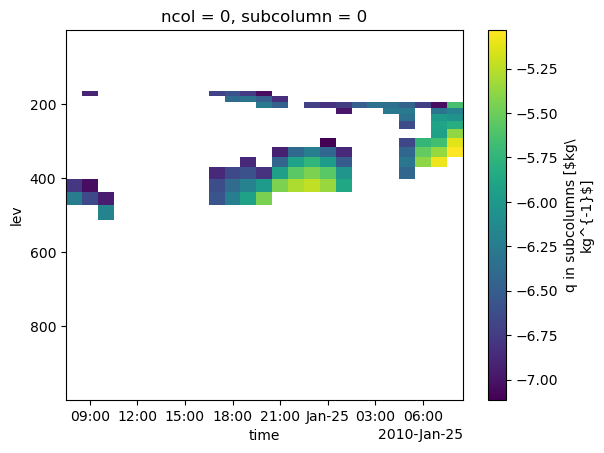

In [9]:
np.log10(e3sm_current_rad.ds["strat_q_subcolumns_ci"][0, :, :, 0]).plot(x="time", ylim=(e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min()))

### Plot allocation of ice number concentration to a single subcolumn

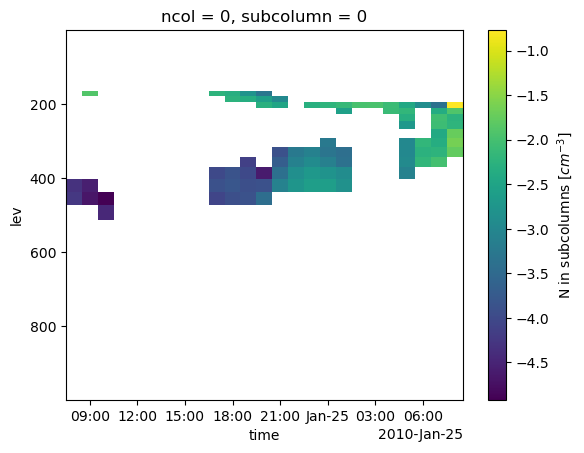

In [10]:
np.log10(e3sm_current_rad.ds["strat_n_subcolumns_ci"][0, :, :, 0]).plot(x="time", ylim=(e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min()))

### Plot denormalized N0 (intercept)

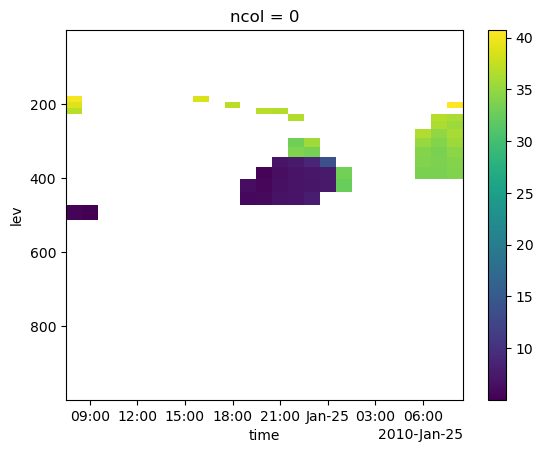

In [11]:
np.log10(e3sm_current_rad.ds["N0_norm_ice"][:,:,0] * e3sm_current_rad.ds["in_cld_Ni"][:,:,0]).plot(x="time", ylim=(e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min()))

### Plot shape parameter ($\mu$)

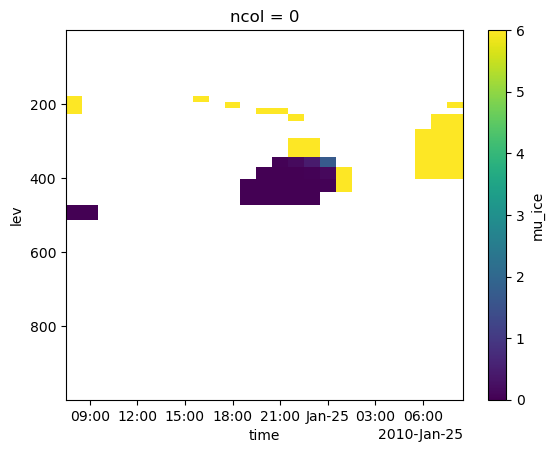

In [12]:
e3sm_current_rad.ds["mu_ice"][:,:,0].plot(x="time", ylim=(e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min()))

### Plot rime fraction

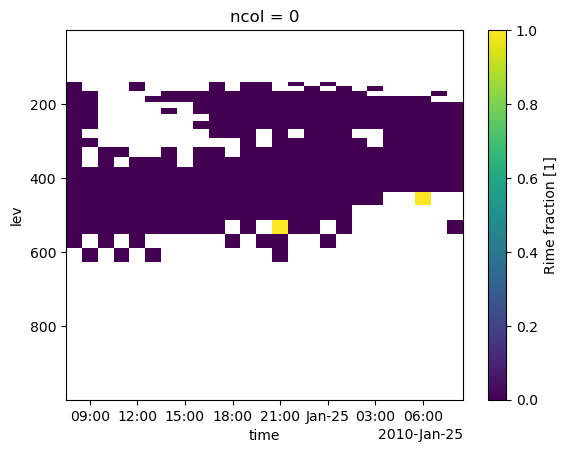

In [13]:
e3sm_current_rad.ds["Fr"][:, :, 0].plot(x="time", ylim=(e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min()))

### Plot rime density

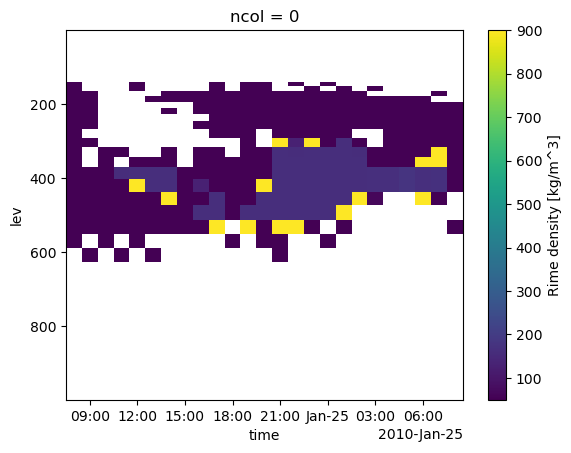

In [14]:
e3sm_current_rad.ds["rho_r"][:, :, 0].plot(x="time", ylim=(e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min()))

### Plot ice effective radius

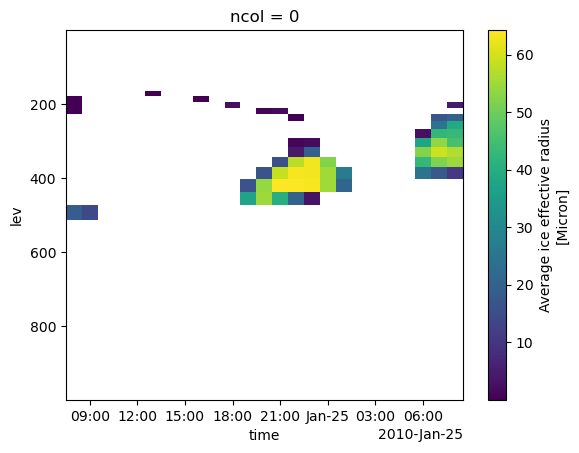

In [15]:
e3sm_current_rad.ds["AREI"][:, :, 0].plot(x="time", ylim=(e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min()))

### Now let's go into details: first let's examine the subcolumn $Z_e$ for ice. Note that minor deviations due to subcolumn allocation are expected.

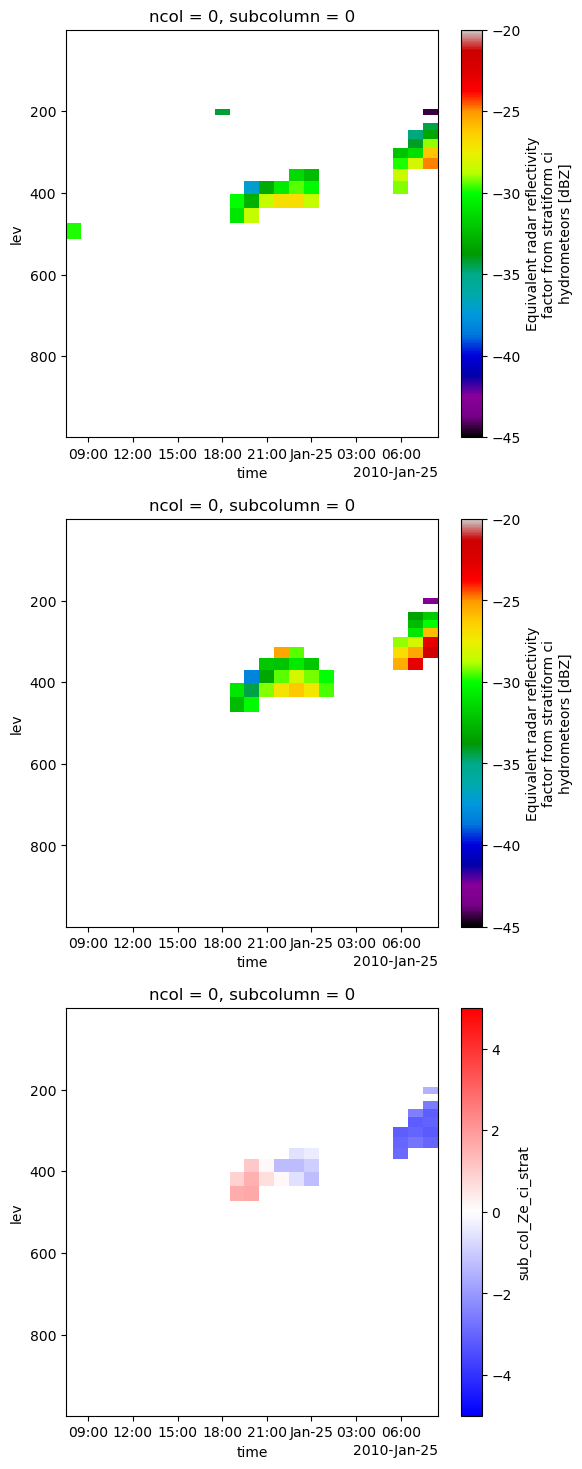

In [16]:
var = "sub_col_Ze_ci_strat"
vmin, vmax = -45, -20
scol = 0  # subcolumns
ncol = 0
cmap = "nipy_spectral"
ylim = (e3sm_current_rad.ds["lev"].max(), e3sm_current_rad.ds["lev"].min())  # will be applicable to all model objects
opts = {}
fig, ax = plt.subplots(3, 1, figsize=(6, 18))
ax = ax.ravel()

e3sm_full_p3_mcp.ds[var][scol, :, :, ncol].plot(x="time", vmin=vmin, vmax=vmax, ylim=ylim, cmap=cmap, ax=ax[0], **opts)
e3sm_current_rad.ds[var][scol, :, :, ncol].plot(x="time", vmin=vmin, vmax=vmax, ylim=ylim, cmap=cmap, ax=ax[1], **opts)

(e3sm_full_p3_mcp.ds[var] - e3sm_current_rad.ds[var])[scol, :, :, ncol].plot(x="time", ylim=ylim, vmin=-5, vmax=5, cmap="bwr", ax=ax[2])

### We can also examine the total $Z_e$ (including cloud water). Here we can see signal from low-level liquid clouds (note the temperature contours in Celsius) 
### Note: recall that we do not include rain in forward calculations by default (see note in the `Model` class initialization cell above)

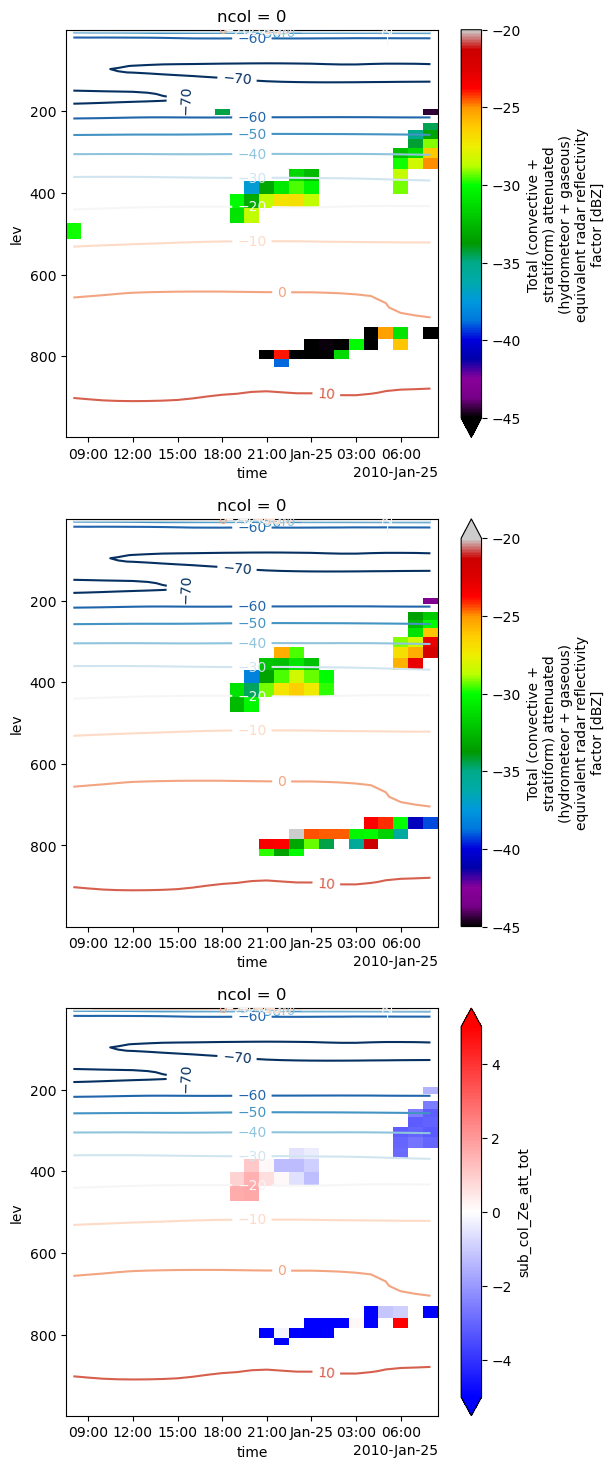

In [17]:
var = "sub_col_Ze_att_tot"
fig, ax = plt.subplots(3, 1, figsize=(6, 18))
ax = ax.ravel()

e3sm_full_p3_mcp.ds[var][scol, :, :, ncol].plot(x="time", vmin=vmin, vmax=vmax, ylim=ylim, cmap=cmap, ax=ax[0], **opts)
e3sm_current_rad.ds[var][scol, :, :, ncol].plot(x="time", vmin=vmin, vmax=vmax, ylim=ylim, cmap=cmap, ax=ax[1], **opts)

(e3sm_full_p3_mcp.ds[var] - e3sm_current_rad.ds[var])[scol, :, :, ncol].plot(x="time", vmin=-5, vmax=5, cmap="bwr", ylim=ylim, ax=ax[2])

for axi in ax:
    CS = (e3sm_full_p3_mcp.ds["T"][:, :, ncol] - 273.15).plot.contour(x="time", levels=np.arange(-70, 30 + 1e-10, 10), color='k', ylim=ylim, ax=axi, **opts)
    # Add labels
    plt.clabel(CS, inline=True, fontsize=10)

### Moving to the lidar (HSRL), we can plot (in log-scale) the backscatter and extinction cross-sections in the same subcolumns and qualitatively examine differences between the approaches.

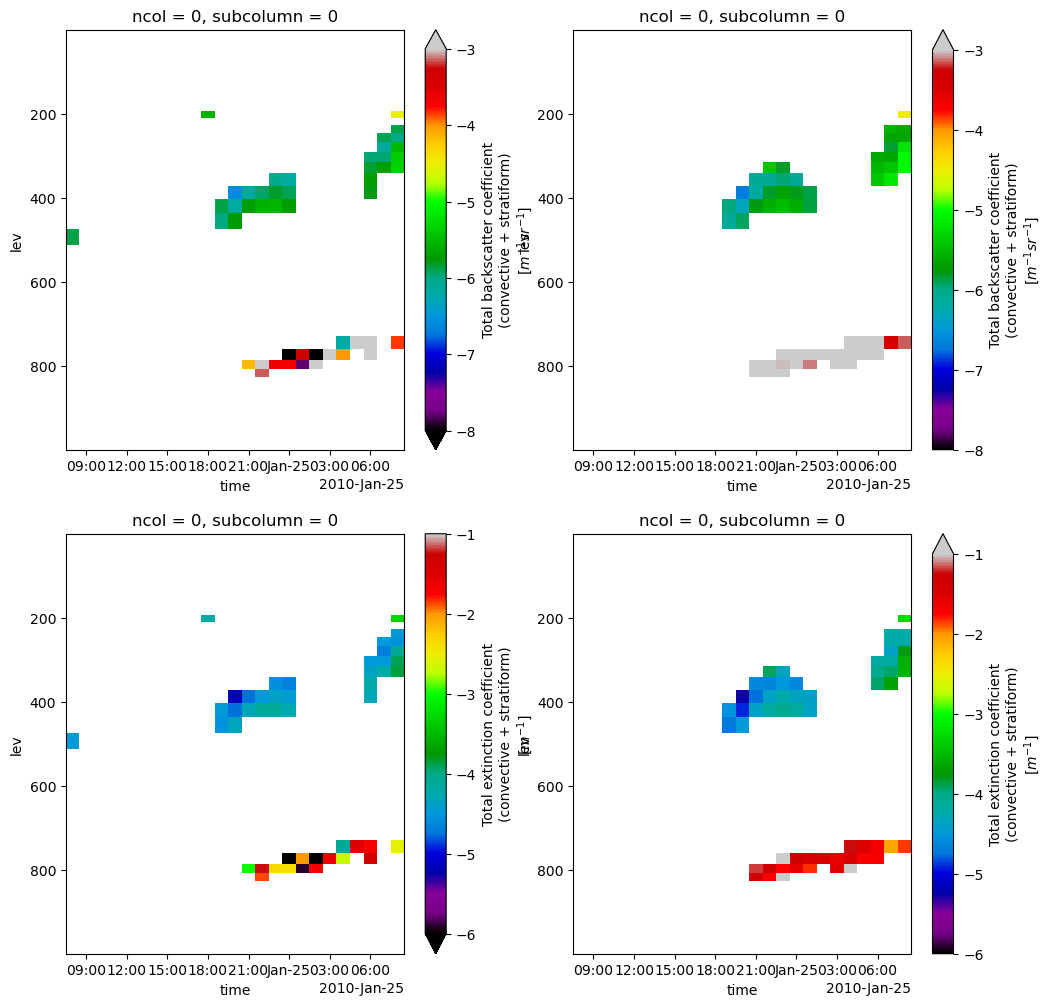

In [18]:
var = "sub_col_beta_p_tot"
var2 = "sub_col_alpha_p_tot"
vmin, vmax = -8, -3
vmin2, vmax2 = -6, -1
scol = 0  # subcolumns
ncol = 0
cmap = "nipy_spectral"
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.ravel()

np.log10(e3sm_full_p3_mcp.ds[var][scol, :, :, ncol]).plot(x="time", vmin=vmin, vmax=vmax, ylim=ylim, cmap=cmap, ax=ax[0], **opts)
np.log10(e3sm_current_rad.ds[var][scol, :, :, ncol]).plot(x="time", vmin=vmin, vmax=vmax, ylim=ylim, cmap=cmap, ax=ax[1], **opts)
np.log10(e3sm_full_p3_mcp.ds[var2][scol, :, :, ncol]).plot(x="time", vmin=vmin2, vmax=vmax2, ylim=ylim, cmap=cmap, ax=ax[2], **opts)
np.log10(e3sm_current_rad.ds[var2][scol, :, :, ncol]).plot(x="time", vmin=vmin2, vmax=vmax2, ylim=ylim, cmap=cmap, ax=ax[3], **opts)

### Finally, back to the radar and focusing on the microphysics, we will plot to higher radar moments

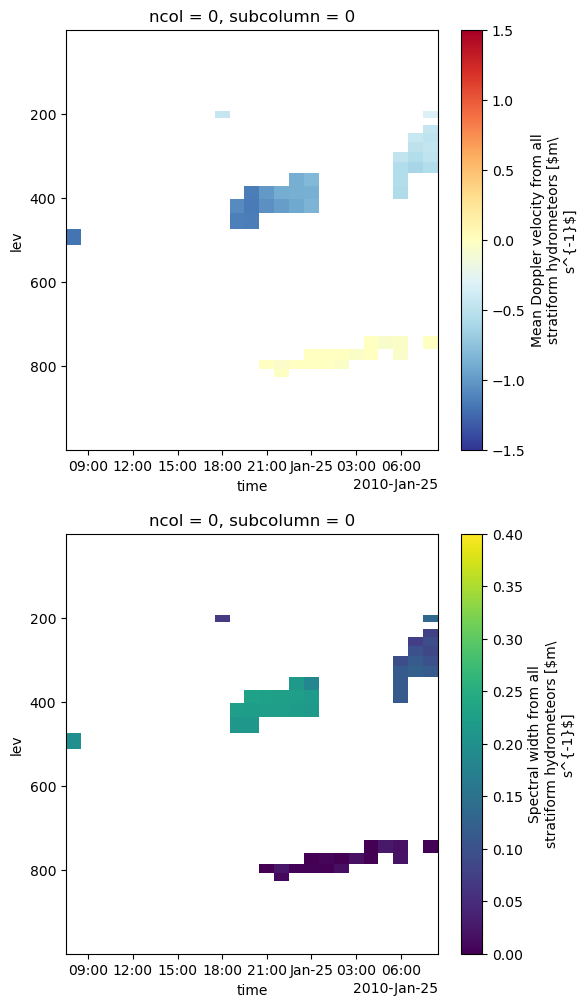

In [19]:
var = "sub_col_Vd_tot_strat"
var2 = "sub_col_sigma_d_tot_strat"
vmin, vmax = -1.5, 1.5
vmin2, vmax2 = 0, 0.4
cmap = "RdYlBu_r"
cmap2 = "viridis"
fig, ax = plt.subplots(2, 1, figsize=(6, 12))
ax = ax.ravel()

e3sm_full_p3_mcp.ds[var][scol, :, :, ncol].plot(x="time", vmin=vmin, vmax=vmax, ylim=ylim, cmap=cmap, ax=ax[0], **opts)
e3sm_full_p3_mcp.ds[var2][scol, :, :, ncol].plot(x="time", vmin=vmin2, vmax=vmax2, ylim=ylim, cmap=cmap2, ax=ax[1], **opts)